# Explore the DESI cutsky:

In order to generate the files in _tests directory, you have to run:

`salloc -N 4 -C haswell -t 00:30:00 --qos interactive -L SCRATCH,project`

`srun -n 256 python from_box_to_desi_cutsky.py`

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from mpytools import Catalog

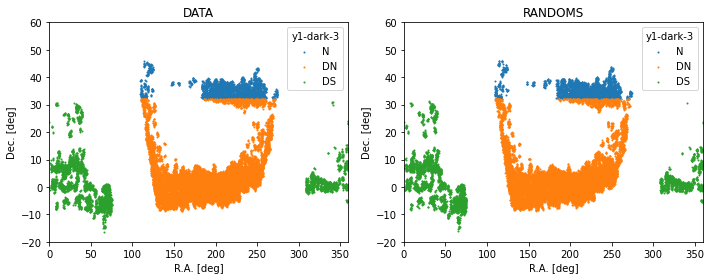

In [101]:
# work with mocks for Y1 data release, dark time with at least 3 observations (in order to increase the completeness of the area)
release, program, npasses = 'y1', 'dark', 3
programpasses = f'{release}-{program}-{npasses}' if npasses is not None else program

# Sky coverage

plt.figure(figsize=(10, 4))
plt.subplot(121)
for region in ['N', 'DN', 'DS']:
    catalog = Catalog.read(f'_tests/data-cutsky-{programpasses}-{region}.fits')
    plt.scatter(catalog['RA'][::10], catalog['DEC'][::10], s=1, label=region)
plt.xlabel('R.A. [deg]')
plt.ylabel('Dec. [deg]')
plt.xlim([0, 360])
plt.ylim([-20, 60])
plt.legend(title=programpasses, loc='upper right')
plt.title('DATA')

plt.subplot(122)
for region in ['N', 'DN', 'DS']:
    catalog = Catalog.read(f'_tests/randoms-cutsky-{programpasses}-{region}-0.fits')
    plt.scatter(catalog['RA'][::10], catalog['DEC'][::10], s=1, label=region)
plt.xlabel('R.A. [deg]')
plt.ylabel('Dec. [deg]')
plt.xlim([0, 360])
plt.ylim([-20, 60])
plt.legend(title=programpasses, loc='upper right')
plt.title('RANDOMS')

plt.tight_layout()
plt.show()

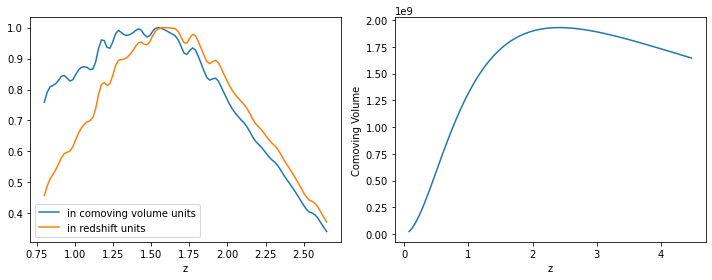

In [100]:
from scipy.interpolate import interp1d
from mockfactory import TabulatedRadialMask
from cosmoprimo.fiducial import DESI

# Load Fiducial Cosmo
cosmo = DESI(engine='class')

# n(z)
zmin, zmax, nz_filename = 0.8, 2.65, 'nz_qso_final.dat'

# Load nz
zbin_min, zbin_max, n_z = np.loadtxt(nz_filename, skiprows=1).T
zbin_mid = (zbin_min + zbin_max) / 2
zedges = np.insert(zbin_max, 0, zbin_min[0])
dedges = cosmo.comoving_radial_distance(zedges)
volume = dedges[1:]**3 - dedges[:-1]**3
nz = interp1d(zbin_mid, n_z / volume, kind='quadratic', bounds_error=False, fill_value=(0, 0))

nz2 = interp1d(zbin_mid, n_z, kind='quadratic', bounds_error=False, fill_value=(0, 0))

z = np.linspace(zmin, zmax, 100)

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(z, nz(z) / nz(z).max(), label='in comoving volume units')
plt.plot(z, nz2(z) / nz2(z).max(), label='in redshift units')
plt.legend()
plt.xlabel('z')
plt.subplot(122)
plt.plot(zbin_mid, dedges[1:]**3 - dedges[:-1]**3)
plt.xlabel('z')
plt.ylabel('Comoving Volume')
plt.tight_layout()
plt.show()

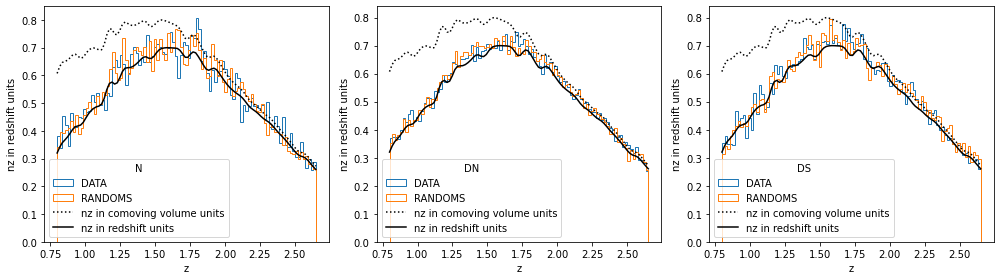

In [99]:
release, program, npasses = 'y1', 'dark', 3
programpasses = f'{release}-{program}-{npasses}' if npasses is not None else program

plt.figure(figsize=(14, 4))
for i, region in enumerate(['N', 'DN', 'DS']):
    plt.subplot(131 + i)
    catalog = Catalog.read(f'_tests/data-cutsky-{programpasses}-{region}.fits')
    plt.hist(catalog['Z'], density=True, histtype='step', bins=z, label='DATA')
    catalog = Catalog.read(f'_tests/randoms-cutsky-{programpasses}-{region}-0.fits')
    plt.hist(catalog['Z'], density=True, histtype='step', bins=z, label='RANDOMS')
    plt.plot(z, nz(z) / nz(z).max() * 0.8, c='k', ls=':', label='nz in comoving volume units')
    plt.plot(z, nz2(z) / nz2(z).max() * 0.7, c='k', label='nz in redshift units')
    plt.legend(title=region)
    plt.xlabel('z')
    plt.ylabel('nz in redshift units')
plt.tight_layout()
plt.show()